In [ ]:
import os
import time
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# tree libs
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

In [34]:
BASE_DIR = Path("..")
MODEL_DIR = BASE_DIR / "src" / "models"
RESULTS_DIR = BASE_DIR / "src" / "results" / "phoenix_models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
DATA_PATH = Path("C:\\Users\\aisha\\OneDrive\\Desktop\\GitHub\\neural-pricer\\data\\raw\\training_data_phoenix.npz")
USE_LOG_TARGET_DEFAULT = True
TEST_SIZE = 0.2
RANDOM_STATE = 42

In [44]:
def rmse(y_true, y_pred):
    # use the new function if available, fall back for older sklearn versions
    try:
        return root_mean_squared_error(y_true, y_pred)
    except Exception:
        return mean_squared_error(y_true, y_pred, squared=False)

def evaluate(y_true, y_pred):
    return {
        "rmse": float(rmse(y_true, y_pred)),
        "mae": float(mean_absolute_error(y_true, y_pred)),
        "r2": float(r2_score(y_true, y_pred)),
    }

def save_lgb_model(lgb_model, path):
    try:
        booster = lgb_model.booster_
    except Exception:
        booster = lgb_model
        booster.save_model(str(path))

In [45]:
arr = np.load(DATA_PATH, allow_pickle=True)
if 'X' not in arr or 'y' not in arr:
    raise RuntimeError(f"NPZ at {DATA_PATH} missing X or y keys")
X = arr['X']
y = arr['y']

meta = {}
if 'meta' in arr:
    meta = arr['meta'].item() if hasattr(arr['meta'], 'item') else dict(arr['meta'])
else:
    # try to look for companion json
    json_path = DATA_PATH.with_suffix('.json')
    if json_path.exists():
        meta = json.loads(json_path.read_text())

feature_order = meta.get('feature_order', [
    'S0', 'r', 'sigma', 'T',
    'autocall_barrier_frac', 'coupon_barrier_frac', 'coupon_rate', 'knock_in_frac'
])
USE_LOG_TARGET = meta.get('use_log_target', USE_LOG_TARGET_DEFAULT)


print(f"Loaded X shape: {X.shape} y shape: {y.shape}")
print("Feature order:", feature_order)
print("Use log target:", USE_LOG_TARGET)

Loaded X shape: (10000, 8) y shape: (10000,)
Feature order: ['S0', 'r', 'sigma', 'T', 'autocall_barrier_frac', 'coupon_barrier_frac', 'coupon_rate', 'knock_in_frac']
Use log target: True


In [46]:
cols = feature_order
if X.shape[1] != len(cols):
    # fallback: generate generic column names
    cols = [f"f{i}" for i in range(X.shape[1])]

df = pd.DataFrame(X, columns=cols)
df['y'] = y
print(df.describe().T)

                         count        mean        std        min        25%  \
S0                     10000.0  100.201848  11.557504  80.002191  90.142559   
r                      10000.0    0.025015   0.014463   0.000006   0.012738   
sigma                  10000.0    0.225767   0.071579   0.100034   0.164048   
T                      10000.0    1.240735   0.435499   0.500122   0.859733   
autocall_barrier_frac  10000.0    1.074727   0.043192   1.000016   1.037316   
coupon_barrier_frac    10000.0    0.800379   0.114900   0.600014   0.702007   
coupon_rate            10000.0    0.027628   0.013067   0.005004   0.016248   
knock_in_frac          10000.0    0.698188   0.115766   0.500025   0.596927   
y                      10000.0    0.705271   0.033191   0.615631   0.681672   

                              50%         75%         max  
S0                     100.351148  110.286689  119.999473  
r                        0.024957    0.037489    0.049997  
sigma                    0.22

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)
print("Train/test sizes:", X_train.shape, X_test.shape)

Train/test sizes: (8000, 8) (2000, 8)


In [48]:
if USE_LOG_TARGET:
    # log1p transform for training stability; invert when evaluating
    y_train_trans = np.log1p(y_train)
    y_test_trans = np.log1p(y_test)
else:
    y_train_trans = y_train
    y_test_trans = y_test

In [49]:
lgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
}
print('\nTraining LightGBM...')
from packaging import version

start = time.time()
lgb_model = lgb.LGBMRegressor(**lgb_params)

if version.parse(lgb.__version__) >= version.parse("4.0.0"):
    lgb_model.fit(
        X_train, y_train_trans,
        eval_set=[(X_test, y_test_trans)],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=0)
        ]
    )
else:
    lgb_model.fit(
        X_train, y_train_trans,
        eval_set=[(X_test, y_test_trans)],
        early_stopping_rounds=50,
        verbose=False
    )

train_time_lgb = time.time() - start
print(f"LightGBM trained in {train_time_lgb:.2f}s (version {lgb.__version__})")


Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 8
[LightGBM] [Info] Start training from score 0.533460
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[733]	valid_0's l2: 5.23828e-06
LightGBM trained in 0.50s (version 4.6.0)


In [50]:
pred_lgb = lgb_model.predict(X_test)
if USE_LOG_TARGET:
    pred_lgb_inv = np.expm1(pred_lgb)
    y_test_inv = np.expm1(y_test_trans)
else:
    pred_lgb_inv = pred_lgb
    y_test_inv = y_test
metrics_lgb = evaluate(y_test_inv, pred_lgb_inv)
metrics_lgb['train_time'] = train_time_lgb

c:\Users\aisha\OneDrive\Desktop\GitHub\neural-pricer\venv\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [52]:
try:
    booster = lgb_model.booster_
    fi = booster.feature_importance(importance_type='gain')
except Exception:
    fi = lgb_model.feature_importances_
fi_df = pd.DataFrame({'feature': cols, 'importance': fi}).sort_values('importance', ascending=False)

print('\nLightGBM performance:')
print(metrics_lgb)
print('\nTop features (LightGBM):')
print(fi_df.head(20).to_string(index=False))

# save model
lgb_path = MODEL_DIR / 'lightgbm_phoenix.txt'
save_lgb_model(lgb_model, lgb_path)


LightGBM performance:
{'rmse': 0.0038997412689809, 'mae': 0.0029843241358637274, 'r2': 0.985884696144763, 'train_time': 0.5039536952972412}

Top features (LightGBM):
              feature  importance
          coupon_rate   10.394891
                sigma    8.839999
                    T    4.791395
  coupon_barrier_frac    2.791725
        knock_in_frac    2.491144
autocall_barrier_frac    1.112157
                    r    0.612690
                   S0    0.027969


In [56]:
xgb_params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'tree_method': 'hist',
}

print("\nTraining XGBoost...")

start = time.time()

xgb_model = xgb.XGBRegressor(**xgb_params)

try:
    from xgboost.callback import EarlyStopping
    xgb_model.fit(
        X_train, y_train_trans,
        eval_set=[(X_test, y_test_trans)],
        callbacks=[EarlyStopping(rounds=50, save_best=True)],
        verbose=False
    )

except ImportError:
    xgb_model.fit(
        X_train, y_train_trans,
        eval_set=[(X_test, y_test_trans)],
        early_stopping_rounds=50,
        verbose=False
    )

except TypeError:
    print("XGBoost early stopping not supported in this version; training without it.")
    xgb_model.fit(X_train, y_train_trans, verbose=False)

train_time_xgb = time.time() - start
print("XGBoost trained in", train_time_xgb)



Training XGBoost...
XGBoost early stopping not supported in this version; training without it.
XGBoost trained in 0.6818466186523438


In [57]:
pred_xgb = xgb_model.predict(X_test)
if USE_LOG_TARGET:
    pred_xgb_inv = np.expm1(pred_xgb)
else:
    pred_xgb_inv = pred_xgb
metrics_xgb = evaluate(y_test_inv, pred_xgb_inv)
metrics_xgb['train_time'] = train_time_xgb

fi_xgb = pd.DataFrame({'feature': cols, 'importance': xgb_model.feature_importances_}).sort_values('importance', ascending=False)
print('\nXGBoost performance:')
print(metrics_xgb)
print('\nTop features (XGBoost):')
print(fi_xgb.head(20).to_string(index=False))

# save model
xgb_path = MODEL_DIR / 'xgboost_phoenix.json'
xgb_model.save_model(str(xgb_path))


XGBoost performance:
{'rmse': 0.003862960787980741, 'mae': 0.0029549030034897424, 'r2': 0.9861496980307655, 'train_time': 0.6818466186523438}

Top features (XGBoost):
              feature  importance
          coupon_rate    0.338738
                sigma    0.254859
                    T    0.154736
  coupon_barrier_frac    0.097329
        knock_in_frac    0.087524
autocall_barrier_frac    0.041755
                    r    0.023175
                   S0    0.001883


In [58]:
print('\nTraining CatBoost...')
start = time.time()
cat_model = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=6, random_seed=RANDOM_STATE, verbose=100)
cat_model.fit(X_train, y_train_trans, eval_set=(X_test, y_test_trans), use_best_model=True)
train_time_cat = time.time() - start
print('CatBoost trained in', train_time_cat)


Training CatBoost...
0:	learn: 0.0187666	test: 0.0185084	best: 0.0185084 (0)	total: 3.44ms	remaining: 3.44s
100:	learn: 0.0032051	test: 0.0034653	best: 0.0034653 (100)	total: 144ms	remaining: 1.28s
200:	learn: 0.0021451	test: 0.0024114	best: 0.0024114 (200)	total: 281ms	remaining: 1.12s
300:	learn: 0.0018386	test: 0.0021342	best: 0.0021342 (300)	total: 413ms	remaining: 960ms
400:	learn: 0.0016913	test: 0.0020154	best: 0.0020154 (400)	total: 554ms	remaining: 828ms
500:	learn: 0.0015942	test: 0.0019548	best: 0.0019548 (500)	total: 685ms	remaining: 682ms
600:	learn: 0.0015227	test: 0.0019188	best: 0.0019188 (600)	total: 821ms	remaining: 545ms
700:	learn: 0.0014640	test: 0.0018963	best: 0.0018963 (700)	total: 954ms	remaining: 407ms
800:	learn: 0.0014133	test: 0.0018802	best: 0.0018802 (800)	total: 1.09s	remaining: 271ms
900:	learn: 0.0013670	test: 0.0018705	best: 0.0018704 (898)	total: 1.23s	remaining: 135ms
999:	learn: 0.0013261	test: 0.0018614	best: 0.0018614 (999)	total: 1.36s	remainin

In [59]:
pred_cat = cat_model.predict(X_test)
if USE_LOG_TARGET:
    pred_cat_inv = np.expm1(pred_cat)
else:
    pred_cat_inv = pred_cat
metrics_cat = evaluate(y_test_inv, pred_cat_inv)
metrics_cat['train_time'] = train_time_cat

In [60]:
# feature importance
fi_cat = pd.DataFrame({'feature': cols, 'importance': cat_model.get_feature_importance()}).sort_values('importance', ascending=False)
print('\nCatBoost performance:')
print(metrics_cat)
print('\nTop features (CatBoost):')
print(fi_cat.head(20).to_string(index=False))

# save model
cat_path = MODEL_DIR / 'catboost_phoenix.cbm'
cat_model.save_model(str(cat_path))


CatBoost performance:
{'rmse': 0.0031581352825089805, 'mae': 0.0023822298656452894, 'r2': 0.9907427902978162, 'train_time': 1.516937017440796}

Top features (CatBoost):
              feature  importance
                sigma   30.110808
          coupon_rate   27.488779
                    T   17.304829
  coupon_barrier_frac   10.062864
        knock_in_frac    9.034524
autocall_barrier_frac    3.969452
                    r    1.972976
                   S0    0.055768


In [61]:
summary = {
    'meta': meta,
    'metrics': {
    'LightGBM': metrics_lgb,
    'XGBoost': metrics_xgb,
    'CatBoost': metrics_cat,
},
    'feature_importances': {
        'LightGBM': fi_df.head(50).to_dict(orient='records'),
        'XGBoost': fi_xgb.head(50).to_dict(orient='records'),
        'CatBoost': fi_cat.head(50).to_dict(orient='records'),
    }
}
summary_path = RESULTS_DIR / 'phoenix_models_summary.json'
with open(summary_path, 'w') as f:
    json.dump(summary, f, indent=2)
print('\nSaved summary to', summary_path)


Saved summary to ..\src\results\phoenix_models\phoenix_models_summary.json


Saved parity plot

Models saved to ..\src\models
Summary saved to ..\src\results\phoenix_models\phoenix_models_summary.json


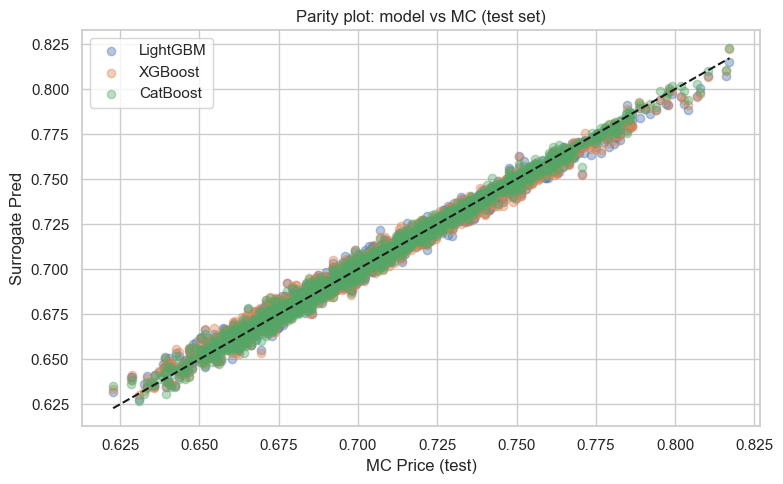

In [62]:
try:
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8,5))
    plt.scatter(y_test_inv, pred_lgb_inv, alpha=0.4, label='LightGBM')
    plt.scatter(y_test_inv, pred_xgb_inv, alpha=0.4, label='XGBoost')
    plt.scatter(y_test_inv, pred_cat_inv, alpha=0.4, label='CatBoost')
    plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'k--')
    plt.xlabel('MC Price (test)')
    plt.ylabel('Surrogate Pred')
    plt.legend()
    plt.title('Parity plot: model vs MC (test set)')
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / 'parity_plot.png')
    print('Saved parity plot')
except Exception as e:
    print('Skipping plots (headless environment):', e)

print('\nModels saved to', MODEL_DIR)
print('Summary saved to', summary_path)